### mask rcnn物件偵測

https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/

In [20]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io

# Import Mask RCNN
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


In [21]:
IMAGE_DIR = '/dataDisk/myfloder/jupyter/Mask_RCNN-master/datasets/bandon/'
MODEL_DIR = '/dataDisk/myfloder/h5/maskrcnn_snapshots/'
class_names = ['BG', '豬肉', '冬粉', '高麗菜', '豆腐', '香腸','豆干','蛋',
               '雞肉','青菜','青椒', "雞腿", "地瓜", "魚", "酸菜", "豬排",'菜豆','豆芽菜']

In [22]:
############################################################
#  Configurations
############################################################
from mrcnn.config import Config
class objectConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "bandon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 17  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [23]:
#config = food.objectConfig()
config = objectConfig()
object_DIR = os.path.join(ROOT_DIR, "datasets/bandon")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                30
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [24]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [25]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", 
                              model_dir=MODEL_DIR,
                              config=config)
# Or, load the last model you trained
#weights_path = model.find_last()
weights_path = '/dataDisk/myfloder/h5/maskrcnn_snapshots/bandon20191220T1051/mask_rcnn_bandon_0115.h5'
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)
#model.keras_model.save('/dataDisk/myfloder/h5/mymaskmodel.h5')
#model.keras_model.summary()

Loading weights  /dataDisk/myfloder/h5/maskrcnn_snapshots/bandon20191220T1051/mask_rcnn_bandon_0115.h5
Re-starting from epoch 115


DSC05874.jpg
Processing 1 images
image                    shape: (667, 1000, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 30)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


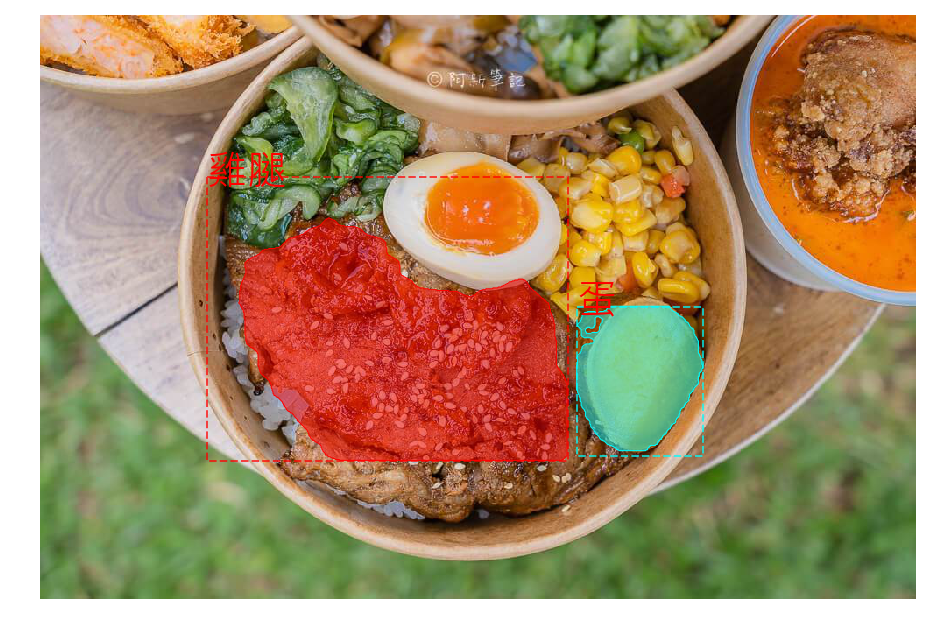

In [36]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
fn = random.choice(file_names)
image = skimage.io.imread(os.path.join(IMAGE_DIR, fn))
print(fn)
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#print(file_names)
#print(np.shape(image))

if image.shape[-1] == 4:    
    image = image[...,:3]
    
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            class_names, 
                            r['scores'])

### no apply

In [ ]:
import Ipynb_importer
from samples.food import food

In [ ]:
import cv2
import numpy as np
 
 
def random_colors(N):
    np.random.seed(1)
    colors=[tuple(255*np.random.rand(3)) for _ in range(N)]
    return colors
 
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] *(1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image
 
def display_instances(image,boxes,masks,ids,names,scores):
    n_instances=boxes.shape[0]
    if not n_instances:
        print('No instances to display')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
    
    colors=random_colors(n_instances)
    height, width = image.shape[:2]
    
    for i,color in enumerate(colors):
        if not np.any(boxes[i]):
            continue
        
        y1,x1,y2,x2=boxes[i]
        mask=masks[:,:,i]
        image=apply_mask(image,mask,color)
        image=cv2.rectangle(image,(x1,y1),(x2,y2),color,2)
        
        label=names[ids[i]]
        score=scores[i] if scores is not None else None
        
        caption='{}{:.2f}'.format(label,score) if score else label
        image=cv2.putText(
            image,caption,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.7,color,2
        )
        
    return image
 
if __name__=='__main__':
    import os
    import sys
    import random
    import math
    import skimage.io
    import time
    import utils
    #import model as modellib
    
    
    ROOT_DIR = os.path.abspath("../")
    sys.path.append(ROOT_DIR)
    from mrcnn import utils
    import mrcnn.model as modellib
 
 
    sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
    import coco
    
 
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        print('cannot find coco_model')
        
    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
 
    config = InferenceConfig()
    config.display()
    
    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
 
    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
    
    
    capture=cv2.VideoCapture(0)
    capture.set(cv2.CAP_PROP_FRAME_WIDTH,1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT,1080)
    
    while True:
        ret,frame=capture.read()
        results=model.detect([frame],verbose=0)
        r=results[0]
        
        
        frame=display_instances(
              frame,r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores']
        )
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(1)&0xFF==ord('q'):
            break
       
    capture.release()
    cv2.destroyAllWindows()


### end